# Disaster Tweets Prediction - Glove and LSTM

# Objective
The aim is to develop a model for predicting whether a tweet is about a real disaster or not.

# Rationale
Inspired from the below mentioned research article:

Aryan Karnati, Shashank Reddy Boyapally, D. S. K. . Natural Language Processing with Disaster tweets using Bidirectional LSTM. J. XI’AN Univ. Archit. Technol. 13, 1–6 (2021).

In [134]:
#import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import re
import nltk
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.util import ngrams
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import  pad_sequences
from tensorflow.keras.models import Model,Sequential
from keras.layers.embeddings import Embedding
from keras import Input
from keras.layers import ( Dense, Dropout, Embedding, LSTM, Flatten, Bidirectional,BatchNormalization,Flatten, 
                          GlobalMaxPool1D )
from keras.models import Model
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

# Data loading

In [58]:
#load data set

train_data = pd.read_csv("C:/Users/sreej/Documents/Kaggle/NLP Tweet classification/Data/train.csv")
test_data = pd.read_csv("C:/Users/sreej/Documents/Kaggle/NLP Tweet classification/Data/test.csv")

In [59]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Data cleansing and EDA

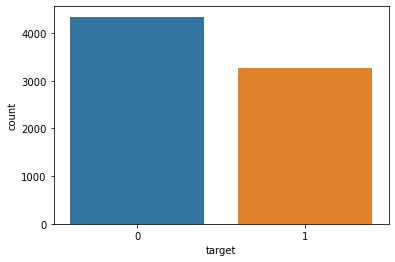

In [128]:
#Plot the disaster tweets(training set) 
sns.countplot(x=train_data['target']);

In [60]:
# Checking if any duplicate records are present in both test and train data
test_duplicate = test_data[test_data.duplicated()] 
test_duplicate

train_duplicate = train_data[train_data.duplicated()] 
train_duplicate

,id,keyword,location,text,target


We found no duplicates in both test and train datasets, hence we proceed for further cleansing of data.

In [61]:
#Remove unwanted colums
test_data = test_data.drop('location',axis = 1) 
train_data = train_data.drop('location',axis = 1)

In [62]:
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

In [63]:
#Remove URL and html tags from the text
train_data['clean_text'] = train_data['text'].apply(cleanhtml)

test_data['clean_text'] = test_data['text'].apply(cleanhtml)

In [64]:
def cleansing_data(text):
    cln_text = re.sub('[^a-zA-Z \n\.]', '', text)
    cln_text = cln_text.lower()
    cln_text = cln_text.split()
    cln_text = ' '.join(cln_text)   
    return cln_text

In [65]:
#Remove speicial characters
test_data['clean_text'] = test_data['clean_text'].apply(cleansing_data)
train_data['clean_text'] = train_data['clean_text'].apply(cleansing_data)

In [66]:
def filter_text(text):
    text = text.split()
    text = [ps.stem(word) for word in text if word not in stopwords.words('english')]
    text = ' '.join(text)
    return text

In [67]:
#Remove suffixes and prefixes
ps = PorterStemmer()

train_data['filtered_text'] = train_data['clean_text'].apply(filter_text)
test_data['filtered_text'] =  test_data['clean_text'].apply(filter_text)

In [82]:
tweet = train_data['filtered_text']
test = test_data['filtered_text']
sentiments = train_data['target']  

# Model
We need to perform tokenization - the processing of segmenting text into sentences of words. In the process we throw away punctuation and extra symbols too. The benefit of tokenization is that it gets the text into a format that is easier to convert to raw numbers, which can actually be used for processing

In [83]:

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(tweet)
vocab_length = len(word_tokenizer.word_index) + 1


In [84]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [85]:
longest_train = max(tweet, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(tweet), length_long_sentence, padding='post')
test_sentences = pad_sequences(
    embed(test), 
    length_long_sentence,
    padding='post'
)

Global Vectors(GloVE) algorithm is used to obtain the vector epresentation of words. Word2Vec relates the target words to their respective context without carrying any additional informations. In comparisoon with Word2Vec, GloVe builds word embeddings in such a way that a combination of word vectors relates directly to the probability of those words’ co-occurrence in the corpus.

In [86]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('C:/Users/sreej/Documents/Kaggle/NLP Tweet classification/glove file/glove.6B.100d.txt','r', encoding='UTF-8')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [87]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [135]:
#Divide the training data into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(
    padded_sentences, 
    sentiments, 
    test_size=0.2,
    random_state=45,
    shuffle=True
)

### Model Generation

In [99]:
#Model generation

model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence))
model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(length_long_sentence, activation = "relu"))
model.add(Dropout(0.5))
#model.add(Dense(length_long_sentence, activation = "relu"))
#model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.summary())
 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 28, 100)           1902900   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 28, 56)            28896     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 56)                0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 56)                224       
_________________________________________________________________
dropout_14 (Dropout)         (None, 56)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 28)                1596      
_________________________________________________________________
dropout_15 (Dropout)         (None, 28)               

### Model training

In [100]:
#Fit the model on data
history = model.fit(
    X_train, 
    y_train, 
    validation_data = (X_valid, y_valid),
    epochs = 10,
    batch_size = 63
)

Epoch 1/10
97/97 [==============================] - 5s 49ms/step - loss: 0.9171 - accuracy: 0.5959 - val_loss: 0.6065 - val_accuracy: 0.6967
Epoch 2/10
97/97 [==============================] - 4s 44ms/step - loss: 0.6403 - accuracy: 0.7095 - val_loss: 0.5693 - val_accuracy: 0.7531
Epoch 3/10
97/97 [==============================] - 4s 44ms/step - loss: 0.5424 - accuracy: 0.7530 - val_loss: 0.5066 - val_accuracy: 0.7820
Epoch 4/10
97/97 [==============================] - 4s 44ms/step - loss: 0.4847 - accuracy: 0.7837 - val_loss: 0.4676 - val_accuracy: 0.7919
Epoch 5/10
97/97 [==============================] - 4s 44ms/step - loss: 0.4275 - accuracy: 0.8146 - val_loss: 0.4440 - val_accuracy: 0.8056
Epoch 6/10
97/97 [==============================] - 4s 46ms/step - loss: 0.3753 - accuracy: 0.8433 - val_loss: 0.4610 - val_accuracy: 0.7991
Epoch 7/10
97/97 [==============================] - 4s 44ms/step - loss: 0.3226 - accuracy: 0.8742 - val_loss: 0.4905 - val_accuracy: 0.7873
Epoch 8/10
97

### Model prediction and evaluation 

In [101]:
y_valid_pred = model.predict_classes(X_valid)

print(confusion_matrix(y_test,y_valid_pred))
print('Accuracy Score :',accuracy_score(y_valid, y_valid_pred))
print('Report : ')
print(classification_report(y_valid, y_valid_pred))

[[760 116]
 [185 462]]
Accuracy Score : 0.8023637557452397
Report : 
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       876
           1       0.80      0.71      0.75       647

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



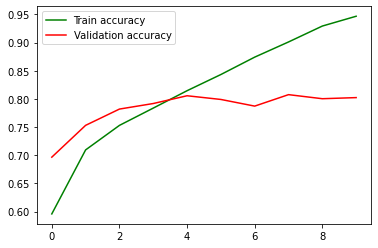

In [103]:
#accuracy per iteration
plt.plot(history.history['accuracy'],color='green',label = 'Train accuracy')
plt.plot(history.history['val_accuracy'],color='red',label = 'Validation accuracy')
plt.legend()